In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
# init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
# import plotly.figure_factory as ff#visualization
import seaborn as sns

In [ ]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(3, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)



In [ ]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

# Práctico 05: Aprendizaje No Supervisado

Realizaremos estudios de segmentación de clientes. Para ello utilizaremos varios métodos de clustering como K-means y DBSCAN ¿Podemos agrupar a clientes propensos a adquirir un plazo fijo? ¿Bajo qué características pueden agruparse esos clientes?

## Objetivo del práctico

### Análisis de clustering con K-means
- Método "Elbow" o codo
- Explicación de cada cluster

### Análisis utilizando Hierarchical Clustering
- Algoritmo de H-Clustering
- Explicación de los clusters

### Análisis utilizando DBSCAN
- Algoritmo de DBSCAN
- Explicación de los clusters

### Resultados Finales
- Elección de clusters útiles
- Explicación a nivel de negocio

### Presentación

Al final del práctico, es necesario hacer 1 o 2 slides que irán incluidos en la presentación final.  
Los slides deberán contener los métodos de cluster que utilizamos y los resultados que obtuvimos. Por último responderemos desde el punto de vista de negocio si este análisis de clustering puede sernos útil.

### Librerías recomendadas

Utilizaremos los métodos de clustering K-means, Hierarchical Clustering y DBSCAN.
Recomiendo el siguiente material:  
- https://scikit-learn.org/stable/modules/clustering.html -> User guide de clustering de scikit-learn
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html -> Referencia de librería scikit-learn, sección de DBSCAN.
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans -> Referencia de librería scikit-learn, sección de KMeans.
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering -> Referencia de librería scikit-learn, sección de un tipo de Hierarchical Clustering.

## Práctico 05: Aprendizaje NO Supervisado - Resolución

In [ ]:
# Leemos el dataset pre-procesado en el Práctico 02.
# Hacemos esto porque tiene aplicada la imputación de datos nulos usando tanto variables
# numéricas como categóricas, cosa que en un pipeline tendríamos que hacer por separado.

# También hemos eliminado los outliers, a lo cual K-means es muy sensible


df = pd.read_csv("/content/final_df.csv")

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_num,marital_num,education_num,loan_num,housing_num,default_num,pca1,pca2,pca3,pca4
0,0,0,0.481481,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.000,999.0,0.000000,nonexistent,1.1,93.994,0.60251,0.957379,5191.0,0,1,1,1,1,1,1,-0.303521,-0.209731,-0.060447,0.074546
1,1,1,0.493827,services,married,high.school,no,no,no,telephone,may,mon,0.000,999.0,0.000000,nonexistent,1.1,93.994,0.60251,0.957379,5191.0,0,2,1,2,1,1,1,-0.306797,-0.177784,-0.159761,0.033756
2,2,2,0.246914,services,married,high.school,no,yes,no,telephone,may,mon,0.000,999.0,0.000000,nonexistent,1.1,93.994,0.60251,0.957379,5191.0,0,2,1,2,1,2,1,-0.302761,-0.190659,-0.074438,0.025968
3,3,3,0.283951,admin.,married,basic.6y,no,no,no,telephone,may,mon,0.000,999.0,0.000000,nonexistent,1.1,93.994,0.60251,0.957379,5191.0,0,3,1,3,1,1,1,-0.305170,-0.170362,-0.142999,0.002977
4,4,4,0.481481,services,married,high.school,no,no,yes,telephone,may,mon,0.000,999.0,0.000000,nonexistent,1.1,93.994,0.60251,0.957379,5191.0,0,2,1,2,2,1,1,-0.302213,-0.223045,-0.020021,0.092061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,39151,41183,0.691358,retired,married,professional.course,no,yes,no,cellular,nov,fri,0.000,999.0,0.000000,nonexistent,-1.1,94.767,0.00000,0.089322,4963.6,1,6,1,5,1,2,1,0.649974,-0.046875,0.175454,-0.222130
39152,39152,41184,0.358025,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,0.000,999.0,0.000000,nonexistent,-1.1,94.767,0.00000,0.089322,4963.6,0,4,1,5,1,1,1,0.653861,-0.048351,0.242347,-0.253567
39153,39153,41185,0.481481,retired,married,university.degree,no,yes,no,cellular,nov,fri,0.125,999.0,0.000000,nonexistent,-1.1,94.767,0.00000,0.089322,4963.6,0,6,1,6,1,2,1,0.639466,0.116860,0.079818,-0.260578
39154,39154,41186,0.333333,technician,married,professional.course,no,no,no,cellular,nov,fri,0.000,999.0,0.000000,nonexistent,-1.1,94.767,0.00000,0.089322,4963.6,1,5,1,5,1,1,1,0.655723,-0.064488,0.295964,-0.234813


### Exploración de variables interesantes

En los prácticos anteriores se trabajó mucho sobre entender qué variables pueden ser más utiles para abordar nuestro problema. En la siguiente celda definimos con qué variables categóricas y numéricas nos quedaremos.

A diferencia del Práctico 4, aquí sí incluimos la variable objetivo o de respuesta ('y'), ya que no estamos buscando hacer una clasificación ni predecirlo, sino encontrar agrupamientos en nuestros datos.

También realizamos un agrupamiento de las cariables Education y Job, replicando lo que hicimos en el TP2

In [ ]:
df['education_groups'] = df['education'].map({'illiterate': 'Basic or less',
                                              'basic.4y': 'Basic or less',
                                               'basic.6y': 'Basic or less',
                                                'basic.9y': 'Basic or less',
                                                  'high.school': 'High School',
                                                   'professional.course': 'Professional',
                                                    'university.degree': 'University'}
                                            )

In [ ]:
#reagrupar las categorías de job 
df['job_groups'] = df['job'].map({'housemaid': 'Sin ingreso Propio',
                                  'student': 'Sin ingreso Propio',
                                  'unemployed': 'Sin ingreso Propio',
                                  'services': 'Servicios',
                                  'admin.': 'Administrtivos',
                                  'retired': 'Ingreso Cuenta Propia o Directivo',
                                  'self-employed': 'Ingreso Cuenta Propia o Directivo',
                                  'entrepreneur': 'Ingreso Cuenta Propia o Directivo',
                                  'management': 'Ingreso Cuenta Propia o Directivo',
                                  'technician': 'Tecnicos',
                                  'blue-collar': 'Operarios' }
                                            )

In [ ]:
variables_categoricas = ['job_groups', 'marital','education_groups','housing', 'loan','contact','poutcome','y',]
variables_categoricas_num = ['job_num'	, 'marital_num'	, 'education_num'	, 'loan_num' ,	'housing_num']
variables_num = ['age', 'campaign','previous','euribor3m','cons.conf.idx','emp.var.rate','cons.price.idx', 'nr.employed']
variables_pca = ['pca1', 'pca2', 'pca3', 'pca4']

variables_numericas = variables_num + variables_pca

### Preprocesamiento

In [ ]:
class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
pipeline_numerico = Pipeline([('select_numeric_columns', SelectColumnsTransformer(variables_num)),
                             ('MinMaxScaler', MinMaxScaler()),
                             ('pca', PCA(n_components=4))
                             ])

pipeline_categorico = Pipeline ([('select_categoric_columns', SelectColumnsTransformer(variables_categoricas)),
                                 ('cat', OneHotEncoder())])

pipeline_completo = ColumnTransformer([('num', pipeline_numerico, variables_num),
                                       ('cat', pipeline_categorico, variables_categoricas)
                                      ])

In [ ]:
data_preprocessed = pipeline_completo.fit_transform(df)

In [ ]:
data_preprocessed[:,0]

array([-0.40309408, -0.4031063 , -0.40286177, ...,  0.74190433,
        0.74717799,  0.7442621 ])

In [ ]:
data_preprocessed.shape

(39156, 28)

El pipeline nos devuelve un _array_ de numpy que es dificil de interpretar. Vamos a regenerar un dataframe que refleje los nombres originales, y de las nuevas features generadas por el OneHotEncoder:

In [ ]:
numeric_features = variables_pca
cat_features = pipeline_completo.transformers_[1][1][1].get_feature_names(variables_categoricas)

In [ ]:
onehot_columns = np.array(cat_features)
numeric_features_list = np.array(numeric_features)
features_list = np.append(numeric_features_list, onehot_columns)

In [ ]:
features_list = list(features_list)

In [ ]:
df_preprocessed = pd.DataFrame(data_preprocessed, columns = features_list )

In [ ]:
df_preprocessed[variables_categoricas_num] = df[variables_categoricas_num]

In [ ]:
df_preprocessed

,pca1,pca2,pca3,pca4,job_groups_Administrtivos,job_groups_Ingreso Cuenta Propia o Directivo,job_groups_Operarios,job_groups_Servicios,job_groups_Sin ingreso Propio,job_groups_Tecnicos,marital_divorced,marital_married,marital_single,education_groups_Basic or less,education_groups_High School,education_groups_Professional,education_groups_University,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,y_0,y_1,job_num,marital_num,education_num,loan_num,housing_num
0,-0.403094,-0.229397,0.031703,0.117174,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,1,1,1
1,-0.403106,-0.230261,0.033218,0.118068,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2,1,2,1,1
2,-0.402862,-0.212975,0.002916,0.100178,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2,1,2,1,2
3,-0.402898,-0.215568,0.007461,0.102862,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3,1,3,1,1
4,-0.403094,-0.229397,0.031703,0.117174,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,0.746823,0.138499,-0.474061,0.738752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,6,1,5,1,2
39152,0.747154,0.161835,-0.514969,0.714601,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4,1,5,1,1
39153,0.741904,0.256927,-0.430523,0.728722,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6,1,6,1,2
39154,0.747178,0.163564,-0.518000,0.712812,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,5,1,5,1,1


Con esto ya nos aseguramos un DF donde todas las variables son numéricas y tienen un mismo rango de valores

### KMeans

#### Selección de variables a clusterizar

In [ ]:
df_preprocessed.columns

Index(['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
       'marital_single', 'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
       'marital_num', 'education_num', 'loan_num', 'housing_num'],
      dtype='object')

In [ ]:
# Por ejemplo education

columns = ['education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University']

#### Elbow method

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (9). Possibly due to duplicate points in X.

/usr/local/lib/python3.7/dist-packages/i

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

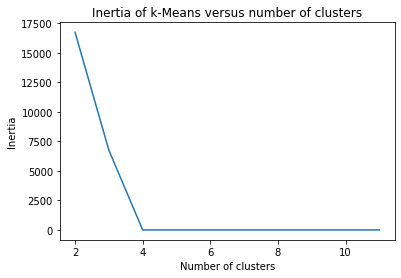

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_preprocessed[columns]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

El método del codo nos sugiere usar 4 clusters para estas columnas, así que lo correremos con esa cantidad:

In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_preprocessed[columns]) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  7.786996147960864e-22


In [ ]:
labeled_df = df[variables_numericas + variables_categoricas].copy()
labeled_df['label'] = clusters

In [ ]:
labeled_df

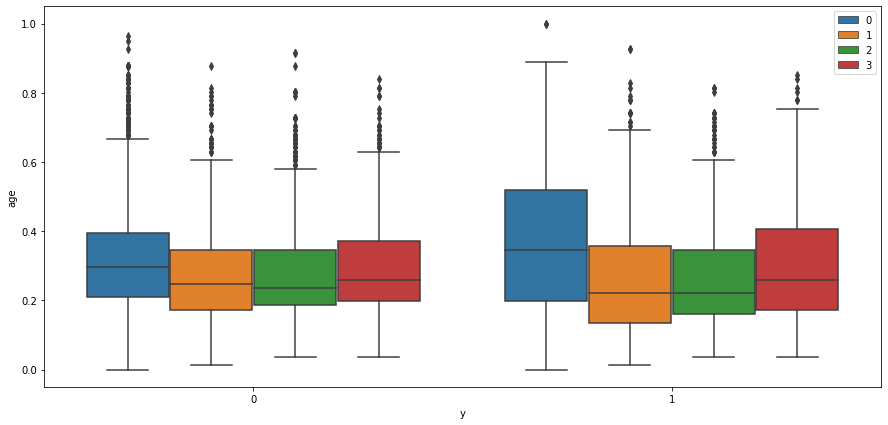

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['y'], y = labeled_df['age'], hue = labeled_df['label'])
plt.legend()
plt.show()

<Figure size 1440x504 with 0 Axes>

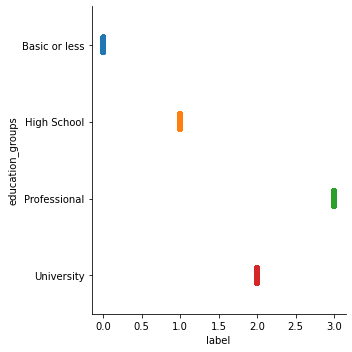

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'education_groups', data = labeled_df)
plt.show()

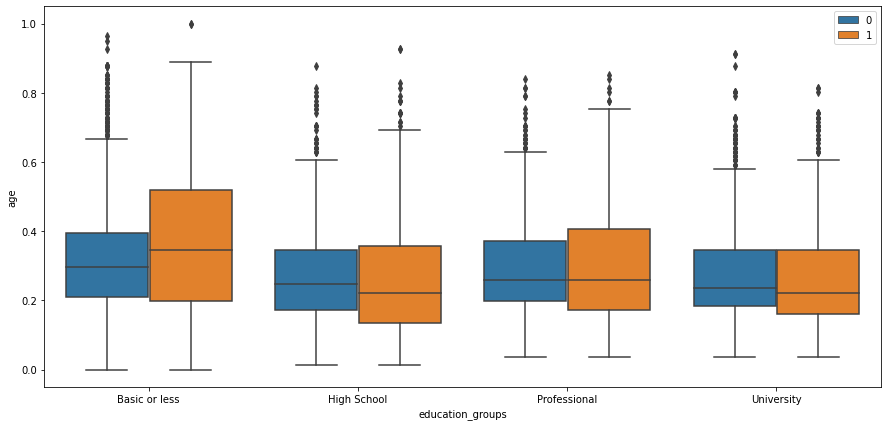

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['education_groups'], y = labeled_df['age'], hue = labeled_df['y'])
plt.legend()
plt.show()

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,3,All
y,,,,,
0,11836,8387,10169,4721,35113
1,1019,937,1519,568,4043
All,12855,9324,11688,5289,39156


#### Intentar explicar los clusters

De esta primera aproximación, pareciera ser que dentro de la población que sí eligió contratar el PF, hay una clase que resalta por presentar una edad promedio más alta. A su vez, esta clase está asociada a niveles de educación más bajos (Basic or Less).

Al graficar esas dos variables juntas, se aprecia que las personas con nivel de educación más bajo tienen efectivamente un promedio de edad mayor.

A continuación repetimos el análisis pero con todas las columnas (categóricas + PCA):

In [ ]:
df_preprocessed.columns

Index(['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
       'marital_single', 'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
       'marital_num', 'education_num', 'loan_num', 'housing_num'],
      dtype='object')

In [ ]:
columns = ['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
       'marital_single', 'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
       'marital_num', 'education_num', 'loan_num', 'housing_num']

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

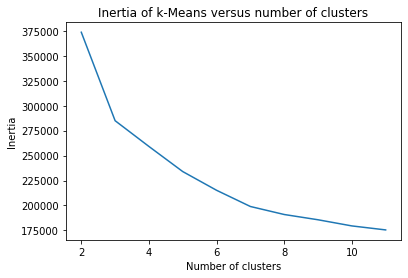

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_preprocessed[columns]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

De la prueba de inercia, parece ser que el número adecuado de Clusters es 3

In [ ]:
# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_preprocessed[columns])

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

labeled_df = df[variables_num + variables_categoricas].copy()
labeled_df[variables_pca] = df_preprocessed[variables_pca]
labeled_df['label'] = clusters

Suma de los cuadrados de las distancias al cluster=Inertia=  284955.5310278224


In [ ]:
labeled_df.columns

Index(['age', 'campaign', 'previous', 'euribor3m', 'cons.conf.idx',
       'emp.var.rate', 'cons.price.idx', 'nr.employed', 'job_groups',
       'marital', 'education_groups', 'housing', 'loan', 'contact', 'poutcome',
       'y', 'pca1', 'pca2', 'pca3', 'pca4', 'label'],
      dtype='object')

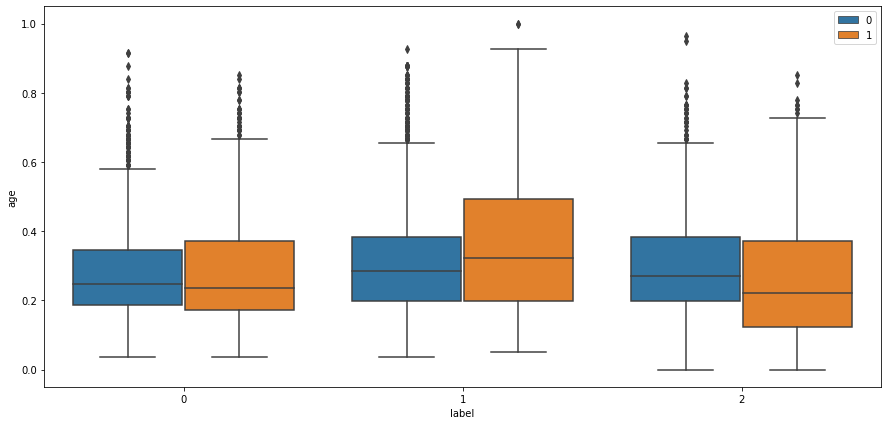

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['age'], hue = labeled_df['y'])
plt.legend()
plt.show()

<Figure size 1440x504 with 0 Axes>

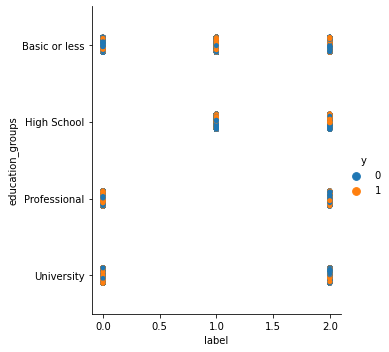

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'education_groups', data = labeled_df, hue = 'y')
plt.show()

<Figure size 1440x504 with 0 Axes>

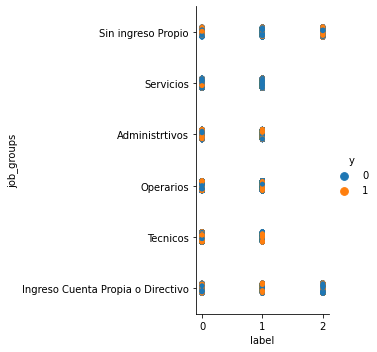

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'job_groups', data = labeled_df, hue = 'y')
plt.show()

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,All
y,,,,
0,15692,12747,6674,35113
1,1859,1229,955,4043
All,17551,13976,7629,39156


En el Cluster 1 se puede observar un promedio de edad más elevado, asociado a quienes sí contrararon el PF. A su vez, en ese Cluster se ve una concentración importante de quienes contrataron el PF en las categorías laborales Técnico e Ingreso Cuenta Propia / Directivo

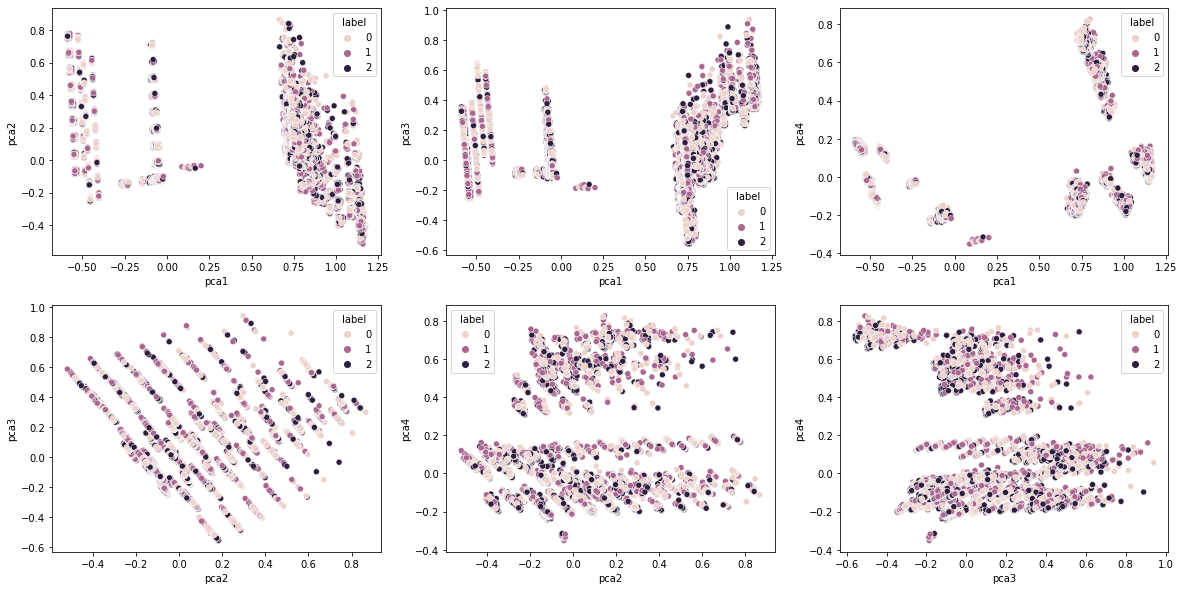

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca2'], hue = labeled_df['label'])
plt.subplot(2,3,2)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca3'], hue = labeled_df['label'])
plt.subplot(2,3,3)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca4'], hue = labeled_df['label'])
plt.subplot(2,3,4)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca3'], hue = labeled_df['label'])
plt.subplot(2,3,5)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca4'], hue = labeled_df['label'])
plt.subplot(2,3,6)
sns.scatterplot(labeled_df['pca3'],labeled_df['pca4'], hue = labeled_df['label'])
plt.show()

En los gráficos de las PCA no se observa ningún agrupamiento claro, veamos qué pasa si nos basamos solo en las PCA para agrupar.

Probamos usando las PCA solamente

In [ ]:
columns = ['pca1', 'pca2', 'pca3', 'pca4']

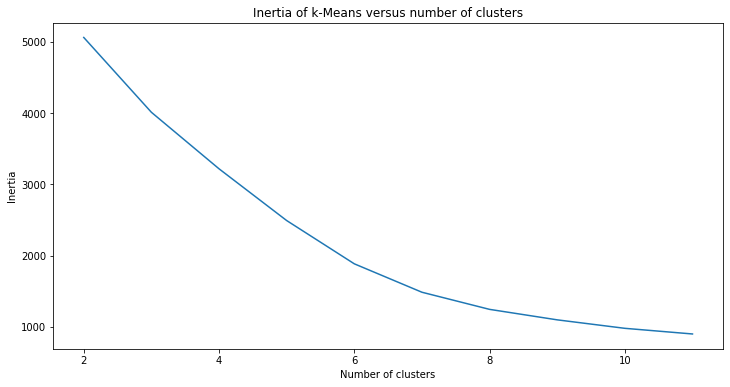

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_preprocessed[columns]).inertia_ for i in range(2,12)]
plt.figure(figsize=(12,6))
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")
plt.show()

In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_preprocessed[columns])

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

labeled_df = df[variables_num + variables_categoricas].copy()
labeled_df[variables_pca] = df_preprocessed[variables_pca]
labeled_df['label'] = clusters

Suma de los cuadrados de las distancias al cluster=Inertia=  3195.289540289108


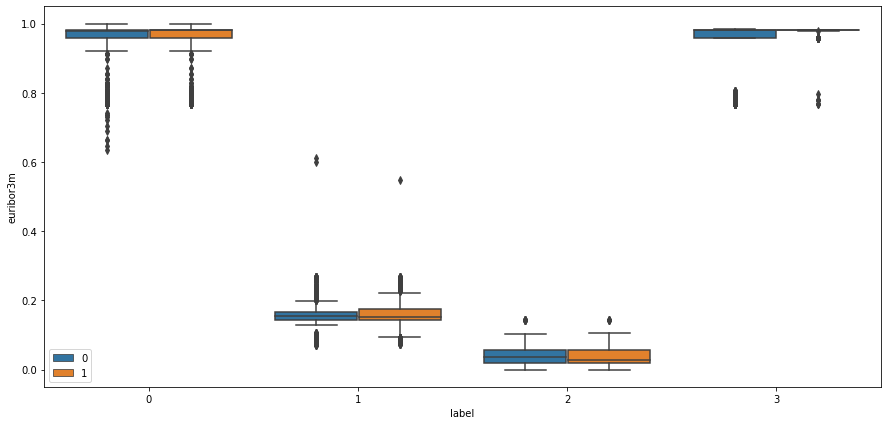

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['euribor3m'], hue = labeled_df['y'])
plt.legend()
plt.show()

<Figure size 1440x504 with 0 Axes>

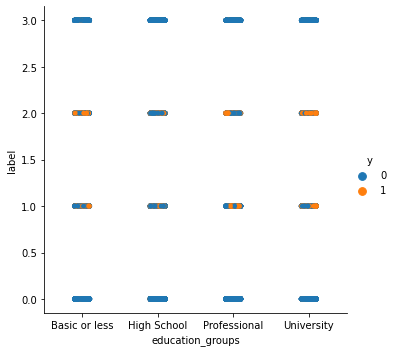

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'education_groups',y = 'label', data = labeled_df, hue = 'y')
plt.show()

<Figure size 1440x504 with 0 Axes>

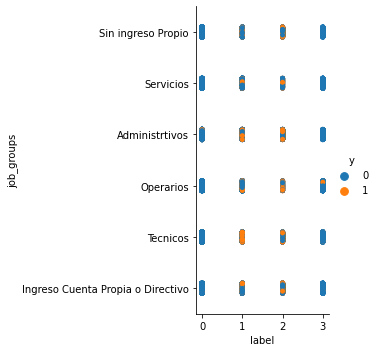

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'job_groups', data = labeled_df, hue = 'y')
plt.show()

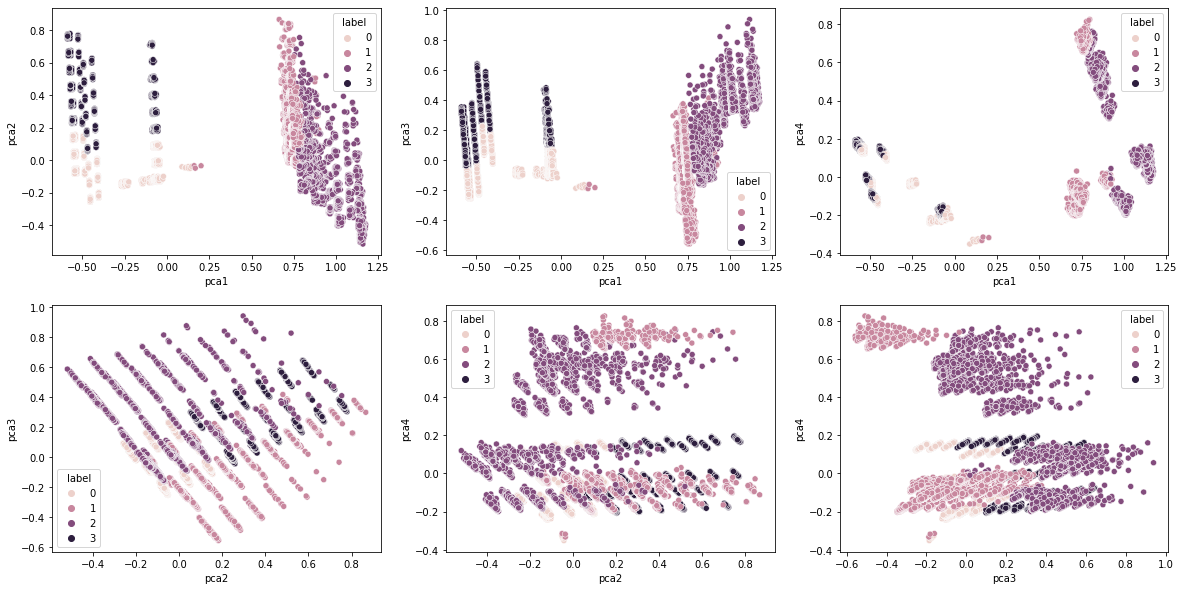

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca2'], hue = labeled_df['label'])
plt.subplot(2,3,2)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca3'], hue = labeled_df['label'])
plt.subplot(2,3,3)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca4'], hue = labeled_df['label'])
plt.subplot(2,3,4)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca3'], hue = labeled_df['label'])
plt.subplot(2,3,5)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca4'], hue = labeled_df['label'])
plt.subplot(2,3,6)
sns.scatterplot(labeled_df['pca3'],labeled_df['pca4'], hue = labeled_df['label'])
plt.show()

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,3,All
y,,,,,
0,20586,7928,2097,4502,35113
1,789,1359,1746,149,4043
All,21375,9287,3843,4651,39156


K-Means parece fallar al encontrar los clusters que claramente se ven en las PCA. Vamos a probar cómo nos va con los otros métodos.

No obstante, adevertimos que la mayoría de los casos de clientes que contrataron el PF se concentran en los clusters 1 y 2, donde claramente tiene influencia la tasa de interés (euribor3m). 

### Hierarchical Clustering

#### Selección de variables a clusterizar

Probamos con todas las columnas

In [ ]:
# columns = ['pca1', 'pca2', 'pca3', 'pca4']

columns = ['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
       'marital_single', 'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
       'marital_num', 'education_num', 'loan_num', 'housing_num']

In [ ]:
# Número de clusters buscado
n_clust = 4

clustering = AgglomerativeClustering(n_clusters=n_clust, linkage = 'complete')
clustering.fit(df_preprocessed[columns])

clusters = clustering.labels_
#cluster_centers = clustering.cluster_centers_

labels_unique = np.unique(clusters)
n_clusters_ = len(labels_unique)

In [ ]:
labeled_df = df[variables_num + variables_categoricas].copy()
labeled_df[variables_pca] = df_preprocessed[variables_pca]
labeled_df['label'] = clusters

<Figure size 1440x504 with 0 Axes>

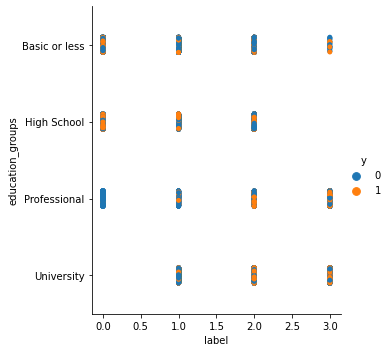

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'education_groups', data = labeled_df, hue = 'y')
plt.show()

<Figure size 1440x504 with 0 Axes>

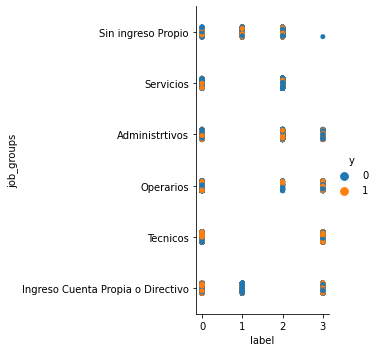

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'job_groups', data = labeled_df,hue = 'y')
plt.show()

<Figure size 1440x504 with 0 Axes>

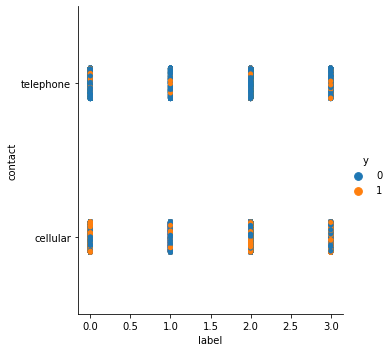

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'contact', data = labeled_df, hue = 'y')
plt.show()

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,3,All
y,,,,,
0,12812,3719,11269,7313,35113
1,1057,579,1367,1040,4043
All,13869,4298,12636,8353,39156


Probamos solo con las PCA:

In [ ]:
columns = ['pca1', 'pca2', 'pca3', 'pca4']

# columns = ['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
#        'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
#        'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
#        'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
#        'marital_single', 'education_groups_Basic or less',
#        'education_groups_High School', 'education_groups_Professional',
#        'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
#        'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
#        'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
#        'marital_num', 'education_num', 'loan_num', 'housing_num']

In [ ]:
# Número de clusters buscado
n_clust = 4

clustering = AgglomerativeClustering(n_clusters=n_clust, linkage = 'complete')
clustering.fit(df_preprocessed[columns])

clusters = clustering.labels_
#cluster_centers = clustering.cluster_centers_

labels_unique = np.unique(clusters)
n_clusters_ = len(labels_unique)

In [ ]:
labeled_df = df[variables_num + variables_categoricas].copy()
labeled_df[variables_pca] = df_preprocessed[variables_pca]
labeled_df['label'] = clusters

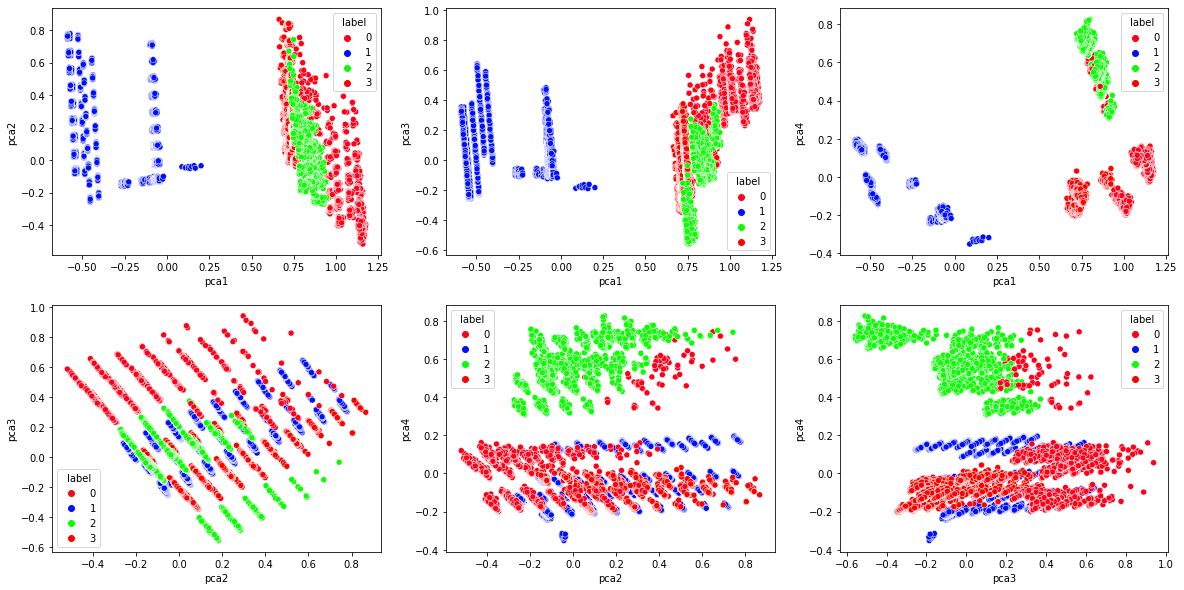

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca2'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,2)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca3'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,3)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,4)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca3'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,5)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,6)
sns.scatterplot(labeled_df['pca3'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.show()

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,3,All
y,,,,,
0,1341,25090,924,7758,35113
1,873,939,1011,1220,4043
All,2214,26029,1935,8978,39156


In [ ]:
labeled_df

In [ ]:
# Verificar como cambian los clusters al modificar los hiperparámetros

#### Intentar explicar los clusters

En los Cluster 0 y 2 encontramos una importante proporción de los casos positivos. A su vez observamos que el cluster 1 es donde menor proporción de casos positivos encontramos. Veamos un poco cómo se refleja eso en las otras variables

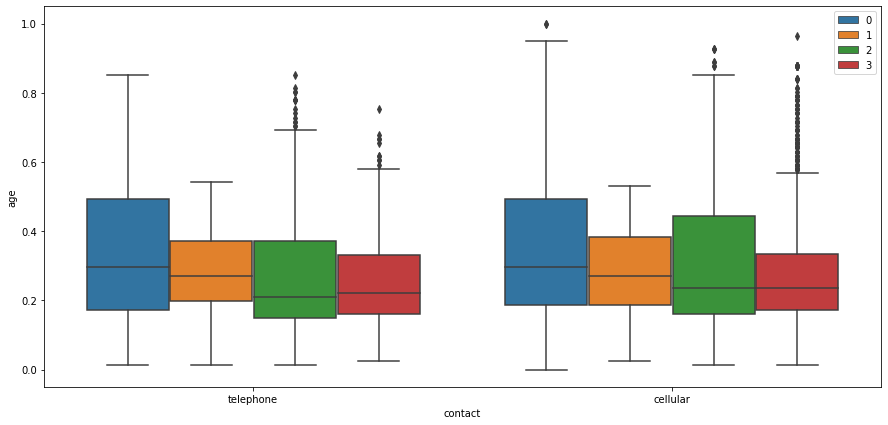

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['contact'], y = labeled_df['age'], hue = labeled_df['label'])
plt.legend()
plt.show()

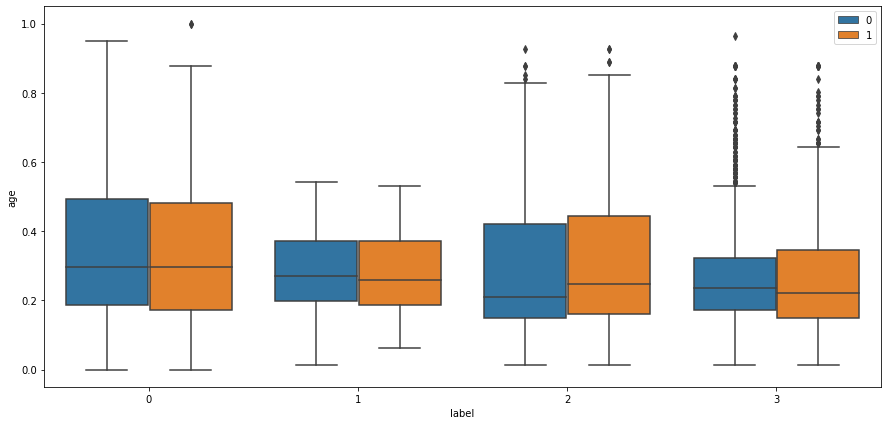

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['age'], hue = labeled_df['y'])
plt.legend()
plt.show()

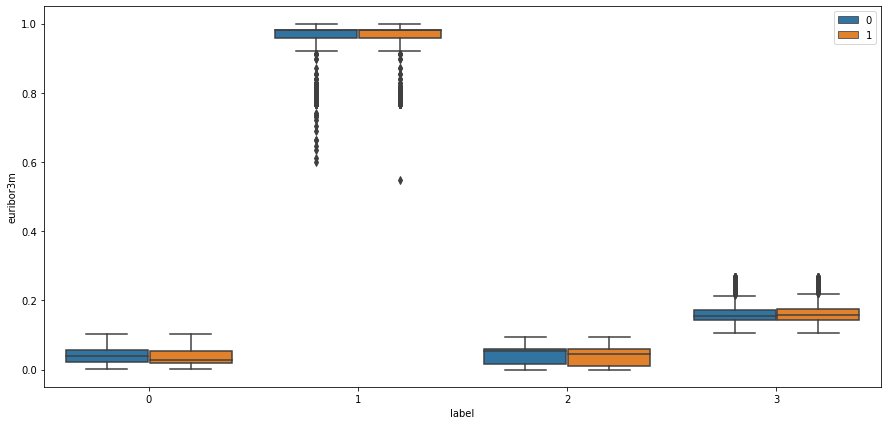

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['euribor3m'], hue = labeled_df['y'])
plt.legend()
plt.show()

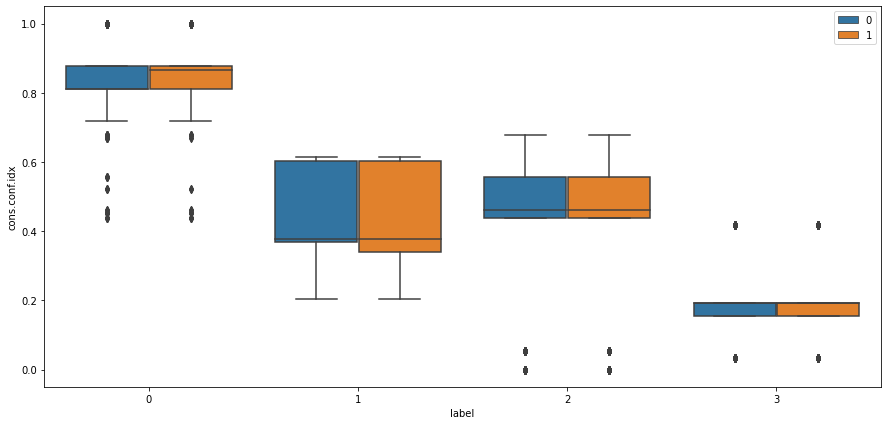

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['cons.conf.idx'], hue = labeled_df['y'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


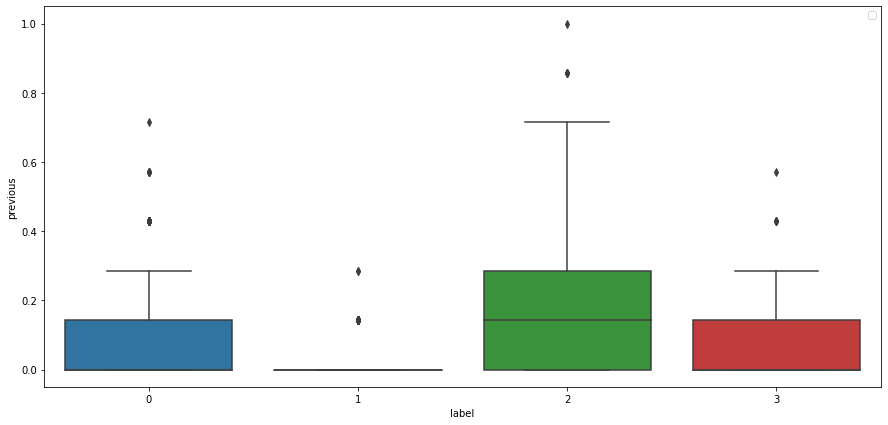

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['previous'])
plt.legend()
plt.show()

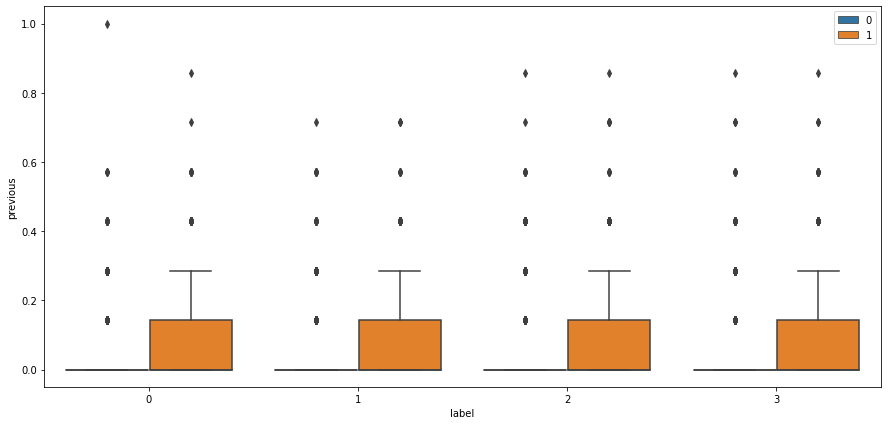

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['previous'], hue = labeled_df['y'])
plt.legend()
plt.show()

<Figure size 1440x504 with 0 Axes>

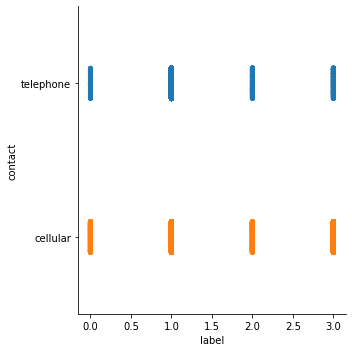

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'contact', data = labeled_df)
plt.show()

<Figure size 1440x504 with 0 Axes>

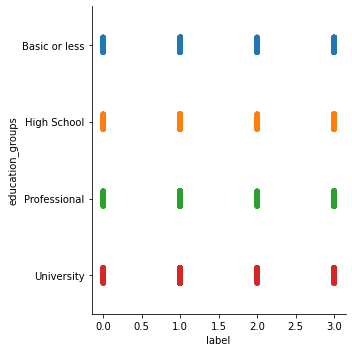

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'education_groups', data = labeled_df)
plt.show()

<Figure size 1440x504 with 0 Axes>

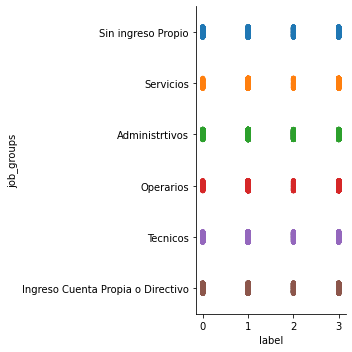

In [ ]:
plt.figure(figsize = (20,7))
sns.catplot(x = 'label',y = 'job_groups', data = labeled_df)
plt.show()

Nuevamente al igual que lo que se vio con KMeans, al usar las PCA solo las variables numéricas son las que tienen incidencia en el clustering. 

### DBSCAN

#### Selección de variables a clusterizar

In [ ]:
columns = ['pca1', 'pca2', 'pca3', 'pca4']

# columns = ['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
#        'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
#        'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
#        'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
#        'marital_single', 'education_groups_Basic or less',
#        'education_groups_High School', 'education_groups_Professional',
#        'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
#        'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
#        'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
#        'marital_num', 'education_num', 'loan_num', 'housing_num']

In [ ]:
# Número de clusters buscado

clustering = DBSCAN(eps = 0.25,min_samples=10,algorithm = 'auto')
clustering.fit(df_preprocessed[list(columns)])
# clustering.fit(df[variables_num + variables_categoricas_num + variables_pca])

clusters = clustering.labels_
#cluster_centers = clustering.cluster_centers_

labels_unique = np.unique(clusters)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por DBSCAN : %d" % n_clusters_)

Cantidad de clusters encontrados por DBSCAN : 5


In [ ]:
labeled_df = df[variables_num + variables_categoricas].copy()
labeled_df[variables_pca] = df_preprocessed[variables_pca]
labeled_df['label'] = clusters

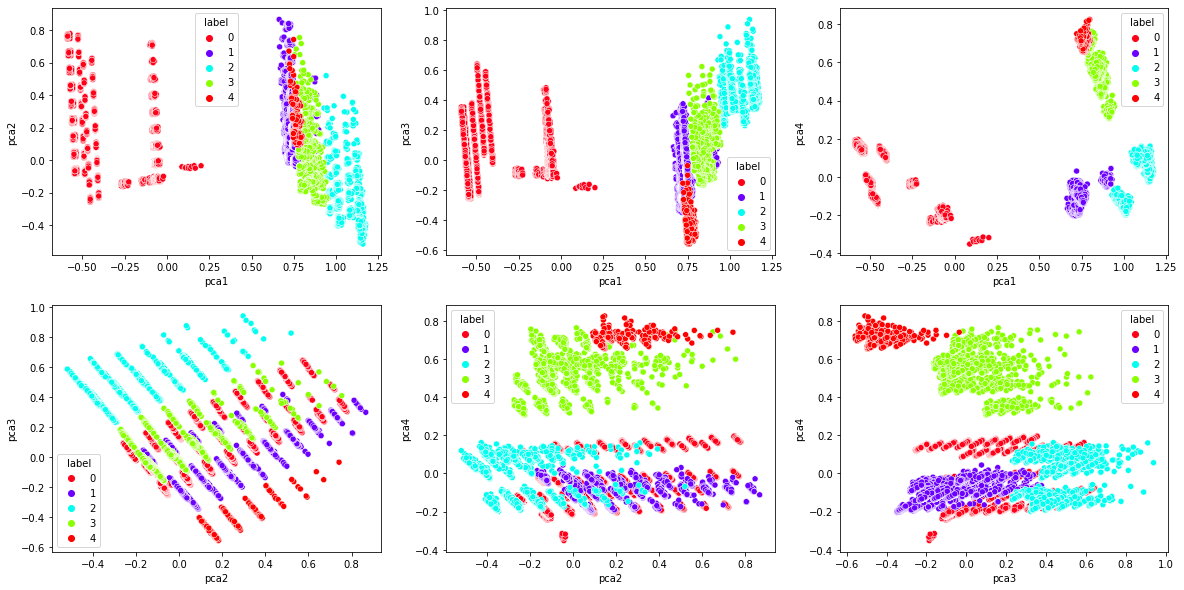

In [ ]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca2'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,2)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca3'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,3)
sns.scatterplot(labeled_df['pca1'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,4)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca3'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,5)
sns.scatterplot(labeled_df['pca2'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.subplot(2,3,6)
sns.scatterplot(labeled_df['pca3'],labeled_df['pca4'], hue = labeled_df['label'], palette= 'hsv_r')
plt.show()

In [ ]:
labeled_df.columns

Index(['age', 'campaign', 'previous', 'euribor3m', 'cons.conf.idx',
       'emp.var.rate', 'cons.price.idx', 'nr.employed', 'job_groups',
       'marital', 'education_groups', 'housing', 'loan', 'contact', 'poutcome',
       'y', 'pca1', 'pca2', 'pca3', 'pca4', 'label'],
      dtype='object')

In [ ]:
# tabla de contiazngencia alguna categórica vs clusters
pd.crosstab(index=labeled_df['y'],
            columns=labeled_df['label'], margins=True)

label,0,1,2,3,4,All
y,,,,,,
0,25090,7758,1290,796,179,35113
1,939,1220,848,890,146,4043
All,26029,8978,2138,1686,325,39156


#### Intentar explicar los clusters

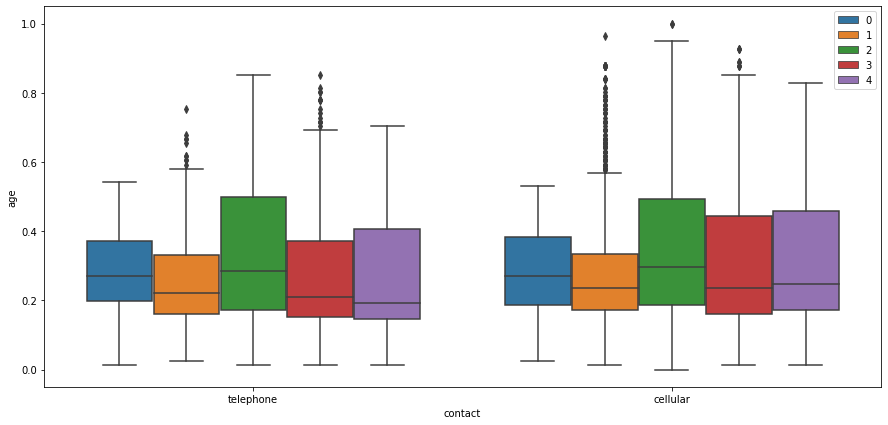

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['contact'], y = labeled_df['age'], hue = labeled_df['label'])
plt.legend()
plt.show()

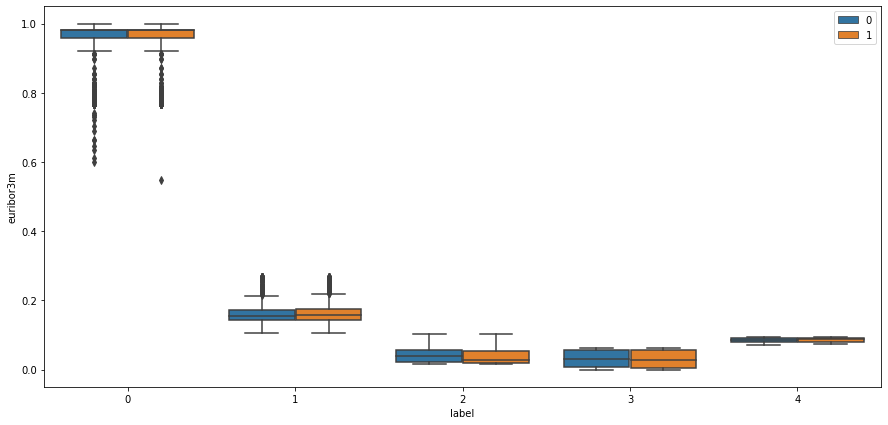

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['euribor3m'], hue = labeled_df['y'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


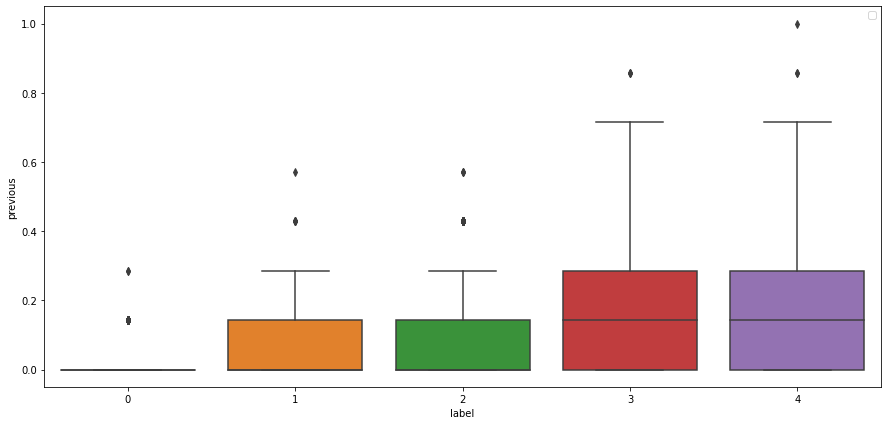

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = labeled_df['label'], y = labeled_df['previous'])
plt.legend()
plt.show()

In [ ]:
# columns = ['pca1', 'pca2', 'pca3', 'pca4']

columns = ['pca1', 'pca2', 'pca3', 'pca4', 'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'marital_divorced', 'marital_married',
       'marital_single', 'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'y_0', 'y_1', 'job_num',
       'marital_num', 'education_num', 'loan_num', 'housing_num']

In [ ]:
# Número de clusters buscado

clustering = DBSCAN(eps = 1,min_samples=10,algorithm = 'auto')
clustering.fit(df_preprocessed[list(columns)])
# clustering.fit(df[variables_num + variables_categoricas_num + variables_pca])

clusters = clustering.labels_
#cluster_centers = clustering.cluster_centers_

labels_unique = np.unique(clusters)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por DBSCAN : %d" % n_clusters_)

Cantidad de clusters encontrados por DBSCAN : 601


Con DBSCAN no fue posible realizar un análisis con todas las variables, ya que encuentra un número demasiado grande de clusters y es muy dificil su interpretación. Para bajar el numero de Clusters habria que aumentar el EPS, pero eso implica mucho consumo de Memoria y no fue posible hacerlo con Colab.

### Conclusión

Resultó complicado encontrar clusters basándose solamente en las variables categóricas. El agrupamiento fue mas claro en cambio cuando nos basamos solo en las numéricas, a través de las PCA.

Para esas variables en particular (las PCA), el método que mejor parece haber funcionado es Hierarchichal Clustering. Afirmamos esto porque además de observar patrones similares en los clusters respecto a variabeles como la edad, la cantidad de contactos previos o la tasa de interés, las PCA en sí se agruparon de manera más adecuada, sin observar tanta mezcla dentro de un mismo _blob_.

Luego de trabajar exhaustivamente con la base de datos, concluimos que para este tipo de problema el análisis de clusters puede ser pensando como parte de un análisis exploratorio, pero para poder predecir si un cliente contratará o no un PF necesariamente hay que usar herramientas de aprendizaje supervisado.
